# Deep Learning Final Project


## Install package and prepare code environment

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [18]:
!pip install bert_score
from bert_score import score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 2.9 MB/s 
     |████████████████████████████████| 5.8 MB 38.1 MB/s 
     |████████████████████████████████| 7.6 MB 65.3 MB/s 
     |████████████████████████████████| 182 kB 80.2 MB/s 


In [20]:
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 24.7 MB/s 


In [19]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
%pip install convokit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 31.5 MB/s 
     |████████████████████████████████| 235 kB 56.0 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 175 kB 78.9 MB/s 
  Created wheel for convokit: filename=convokit-2.5.3-py3-none-any.whl size=204129 sha256=5d0cddb9a85c759df992bca7b0f5712c261eb1fd1d73c05e610045edbce18c9b
  Stored in directory: /root/.cache/pip/wheels/7f/b7/c5/e64a27e4785b38aeff5ed75b50406be08d7f2d4216a094f073
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=56dbcd96928a328033e0da214319e2ab2058820201e57401528a5ab8f462618f
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built convokit emoji


## Prepare Dataset


In [14]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))
cp = corpus.get_utterances_dataframe()["text"]
cp[:10]

id
L1045                                         They do not!
L1044                                          They do to!
L985                                            I hope so.
L984                                             She okay?
L925                                             Let's go.
L924                                                   Wow
L872        Okay -- you're gonna need to learn how to lie.
L871                                                    No
L870     I'm kidding.  You know how sometimes you just ...
L869                      Like my fear of wearing pastels?
Name: text, dtype: object

In [ ]:
cp[12]

"I figured you'd get to the good stuff eventually."

### Preprocessing the dataset
1. Merge the text

In [15]:
text = list(cp[:1000])
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
len(text.split())

8598

2. Clean the text \
  2.1 Uniform uppercase and lowercase letters \
  2.2 Clean up punctuations

In [21]:
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)

3. Convert text to number vector


In [23]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

### Prepare the model 

|  Layer |  input size | output size  |   |   |
|---|---|---|---|---|
|  Embedding | (2)  | (1,1,200)  |   |   |
| RNN/LSTM/GRU  | (1,1,200)  | (1,100)  |   |   |
| Linear  | (1,100)  | (1,1715)  |   |   |

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)).cuda()
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self, batch_size = 1):
      state_dim = (self.n_layers, 1, self.hidden_size)
      return (torch.zeros(state_dim).cuda(), torch.zeros(state_dim).cuda())

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, (h, c) = self.lstm(input.view(1, 1, -1), hidden)
        
        output = self.decoder(output.view(1, -1))

        return output, (h,c)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)).cuda()

#### Parameters of Network Architecture

In [ ]:
from torchsummary import summary

rnn_params = sum(
	param.numel() for param in RNN(1715, 100, 1715).parameters()
)
print(rnn_params)
from torchsummary import summary

lstm_params = sum(
	param.numel() for param in LSTM(1715, 100, 1715).parameters()
)
print(lstm_params)

gru_params = sum(
	param.numel() for param in GRU(1715, 100, 1715).parameters()
)
print(gru_params)

374915
465515
435315


#### Prepare evaluate method (Generating sentence by given words)

In [9]:
def evaluate(decoder, prime_str, predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()
    for p in range(predict_len):
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:]
        output, hidden = decoder(inp, hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

def lstmevaluate(decoder, prime_str, predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    for p in range(predict_len):
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:]
        output, hidden = decoder(inp, hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

#### Model Training

In [ ]:
n_epochs = 60
print_every = 2
plot_every = 1
hidden_size = 100
n_layers = 1
lr = 0.015
def train_plot(model):
  decoder = model(voc_len, hidden_size, voc_len, n_layers)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  all_losses = []
  loss_avg = 0
  decoder.cuda()
  for epoch in range(1, n_epochs + 1):  
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
      output, hidden = decoder(inp[c].cuda(), hidden)
      loss += criterion(output, tar[c].cuda())


    loss.backward()
    decoder_optimizer.step()

    loss = loss.data.item() / chunk_len

    loss_avg += loss

    if epoch % print_every == 0:
        print( 'epoch:', epoch, 'loss:', loss)

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

  return decoder, all_losses

In [ ]:
model_rnn, rnn_losses = train_plot(RNN)
model_lstm, lstm_losses = train_plot(LSTM)
model_gru, gru_losses = train_plot(GRU)

epoch: 2 loss: 6.939044014811079
epoch: 4 loss: 5.8851256562958545
epoch: 6 loss: 4.932155416017058
epoch: 8 loss: 4.073933232643983
epoch: 10 loss: 3.236908115714417
epoch: 12 loss: 2.4908582501261005
epoch: 14 loss: 1.8912338290420947
epoch: 16 loss: 1.4276523380181585
epoch: 18 loss: 1.0661918433029163
epoch: 20 loss: 0.785655457572909
epoch: 22 loss: 0.5730894876593452
epoch: 24 loss: 0.4145105687992938
epoch: 26 loss: 0.29701310155676813
epoch: 28 loss: 0.21192427234271827
epoch: 30 loss: 0.1510738224468945
epoch: 32 loss: 0.10870014283032603
epoch: 34 loss: 0.07951344345215919
epoch: 36 loss: 0.05941780297439586
epoch: 38 loss: 0.04547545950113634
epoch: 40 loss: 0.03550021086907614
epoch: 42 loss: 0.028320894640154987
epoch: 44 loss: 0.023042958708082328
epoch: 46 loss: 0.019132814246420465
epoch: 48 loss: 0.016170862747830497
epoch: 50 loss: 0.013916825863340717
epoch: 52 loss: 0.012152850234324846
epoch: 54 loss: 0.010762305620043749
epoch: 56 loss: 0.009647642962650962
epoch:

#### Data Plot


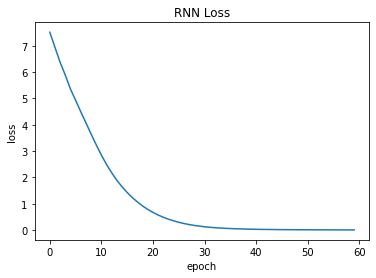

In [ ]:
plt.title('RNN Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(rnn_losses)
plt.show()

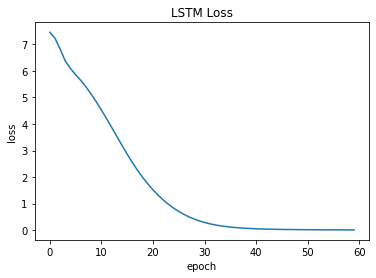

In [ ]:
plt.title('LSTM Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(lstm_losses)
plt.show()

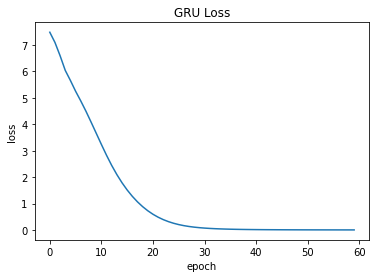

In [ ]:
plt.title('GRU Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(gru_losses)
plt.show()

### Text Generation and BertScore

In [38]:
# data
cands = ['i figured']
refs = ['I figured you get to the good stuff eventually']

print(evaluate(model_rnn, prime_str='i figured', predict_len=6),'\n')
rnn_pred = evaluate(model_rnn, prime_str='i figured', predict_len=7)

P, R, F1 = score([rnn_pred], refs, lang="eg", verbose=True)

print(f"System level F1 score in RNN : {F1.mean():.3f}") 


i figured verdict choice something loss considering play 



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.02 sentences/sec
System level F1 score in RNN : 0.658


In [47]:
# data
cands = ['i figured']
refs = ['I figured you get to the good stuff eventually']

print(evaluate(model_rnn, prime_str='i figured', predict_len=6),'\n')
rnn_pred = lstmevaluate(model_lstm, prime_str='i figured', predict_len=7)

P, R, F1 = score([rnn_pred], refs, lang="eg", verbose=True)

print(f"System level F1 score in LSTM : {F1.mean():.3f}") 

i figured came choice back myself korrine drink 



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.17 seconds, 5.87 sentences/sec
System level F1 score in LSTM : 0.664


In [59]:
# data
cands = ['i figured']
refs = ['I figured you get to the good stuff eventually']

print(evaluate(model_rnn, prime_str='i figured', predict_len=6),'\n')
rnn_pred = evaluate(model_gru, prime_str='i figured', predict_len=7)

P, R, F1 = score([rnn_pred], refs, lang="eg", verbose=True)

print(f"System level F1 score in GRU : {F1.mean():.3f}") 

i figured could hospital likes kidding helpful deal 



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.41 sentences/sec
System level F1 score in GRU : 0.696


### GPT Implementation

In [ ]:
#get transformers
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

#view model parameters
GPT2.summary()

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124439808 
 r)                                                              
                                                                 
Total params: 124,439,808
Trainable params: 124,439,808
Non-trainable params: 0
_________________________________________________________________


#### GPT Text Generation

In [ ]:
#get deep learning basics
import tensorflow as tf
tf.random.set_seed(1)

input_sequence = "i figured"
# encode context the generation is conditioned on
input_ids = tokenizer.encode(input_sequence, return_tensors='tf')

greedy_output = GPT2.generate(input_ids, max_length = 16)

# print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens = True))

i figured that he could use the money to buy a new car.




## Model Save and Load

In [ ]:
import pickle 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/rnn.pickle', 'wb') as rnnf, \
  open('/content/drive/MyDrive/lstm.pickle', 'wb') as lstmf, \
  open('/content/drive/MyDrive/gru.pickle', 'wb') as gruf:
  pickle.dump(model_rnn, rnnf)
  pickle.dump(model_lstm, lstmf)
  pickle.dump(model_gru, gruf)
  rnnf.close()
  lstmf.close() 
  gruf.close() 

In [6]:
with open('/content/drive/MyDrive/rnn.pickle', 'rb') as rnnf, \
  open('/content/drive/MyDrive/lstm.pickle', 'rb') as lstmf, \
  open('/content/drive/MyDrive/gru.pickle', 'rb') as gruf:
  model_rnn = pickle.load(rnnf)
  model_lstm = pickle.load(lstmf)
  model_gru = pickle.load(gruf)
  rnnf.close()
  lstmf.close() 
  gruf.close() 